# Machine Learning Project - 2: Handwritten Letter Classification Challenge 

## Suresh Hastimal Jat

## 202100993

## TY BSC CS

### Importing all necessary Libraries

In [51]:
import shutil
import random
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import cv2

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

### Spliting the data into train and test tests (80% train and 20% test) 

In [1]:
# Set the path to your dataset
dataset_path = "C:/Users/91808/Desktop/HandwringClassification/letters"
train_path = "C:/Users/91808/Desktop/HandwringClassification/letters/train"
test_path = "C:/Users/91808/Desktop/HandwringClassification/letters/test"

# Get the list of all image files
all_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".png"):
            all_files.append(os.path.join(root, file))

# Assign labels based on directory names
labels = [int(os.path.basename(os.path.dirname(file))) for file in all_files]

# Split the data into train and test sets (80% train, 20% test)
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=42
)

# Create directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Move files to train directory
for file, label in zip(train_files, train_labels):
    dest = os.path.join(train_path, str(label))
    os.makedirs(dest, exist_ok=True)
    shutil.copy(file, dest)

# Move files to test directory
for file, label in zip(test_files, test_labels):
    dest = os.path.join(test_path, str(label))
    os.makedirs(dest, exist_ok=True)
    shutil.copy(file, dest)

# Checking if the split and directory creation worked properly
print("Number of training samples:", len(train_files))
print("Number of testing samples:", len(test_files))


Number of training samples: 1840
Number of testing samples: 460


### Loading Images and labels for Dimension Reduction

### Applied PCA and t-SNE techniques for Dimension Reduction

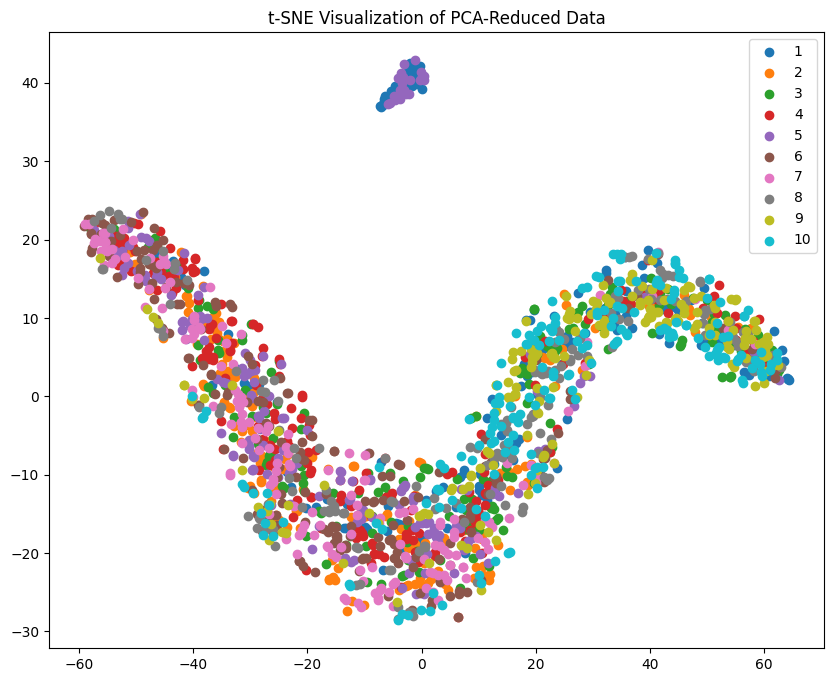

In [14]:
# Function to load images and labels for dimension reduction
def load_images_and_labels(directory, target_shape=(32, 32, 4)):
    images, labels = [], []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".png"):
                image_path = os.path.join(root, file)
                label = int(os.path.basename(root))
                img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
                # Resize the image to the target shape
                img_resized = cv2.resize(img, (target_shape[1], target_shape[0]))
                images.append(img_resized)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load training data for dimension reduction
train_directory = "C:/Users/91808/Desktop/HandwringClassification/letters/train"
train_images, train_labels = load_images_and_labels(train_directory)

# Reshape the images to (32*32*4) for PCA
flat_train_images = train_images.reshape((len(train_images), -1))

# Step 1: Apply PCA
pca = PCA(n_components=50)  # Adjust the number of components as needed
pca_result = pca.fit_transform(flat_train_images)

# Step 2: Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

# Plot the results
plt.figure(figsize=(10, 8))
for i in range(1, 11):  # Assuming 10 classes
    indices = np.where(train_labels == i)
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=str(i))
plt.title("t-SNE Visualization of PCA-Reduced Data")
plt.legend()
plt.show()


### Training a classification model using neural networks and support vector machines on the training data

In [15]:
# Load testing data
test_directory = "C:/Users/91808/Desktop/HandwringClassification/letters/test"
test_images, test_labels = load_images_and_labels(test_directory)

# Reshape the images to (32*32*4) for classification
flat_test_images = test_images.reshape((len(test_images), -1))

# Standardize the data
scaler = StandardScaler()
flat_train_images_standardized = scaler.fit_transform(flat_train_images)
flat_test_images_standardized = scaler.transform(flat_test_images)

# Train a neural network
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
nn_model.fit(flat_train_images_standardized, train_labels)

# Train an SVM (this might take some time)
svm_model = make_pipeline(StandardScaler(), SVC(C=1, kernel='linear', random_state=42))
svm_model.fit(flat_train_images_standardized, train_labels)

# Make predictions on the test data
nn_predictions = nn_model.predict(flat_test_images_standardized)
svm_predictions = svm_model.predict(flat_test_images_standardized)

# Evaluate the models
nn_accuracy = accuracy_score(test_labels, nn_predictions)
svm_accuracy = accuracy_score(test_labels, svm_predictions)

print("Neural Network Accuracy:", nn_accuracy)
print("SVM Accuracy:", svm_accuracy)


Neural Network Accuracy: 0.5021739130434782
SVM Accuracy: 0.5391304347826087


### Fine-tuning the parameters to increase the classification accuracies of the model on training and test data

In [16]:
# Neural Network Parameter Tuning
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'alpha': [0.0001, 0.001, 0.01],
}

grid_search_nn = GridSearchCV(MLPClassifier(max_iter=500, random_state=42), param_grid_nn, cv=3)
grid_search_nn.fit(flat_train_images_standardized, train_labels)

best_nn_model = grid_search_nn.best_estimator_

# SVM Parameter Tuning
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
}

grid_search_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3)
grid_search_svm.fit(flat_train_images_standardized, train_labels)

best_svm_model = grid_search_svm.best_estimator_

# Evaluate the best models on the test data
best_nn_predictions = best_nn_model.predict(flat_test_images_standardized)
best_svm_predictions = best_svm_model.predict(flat_test_images_standardized)

best_nn_accuracy = accuracy_score(test_labels, best_nn_predictions)
best_svm_accuracy = accuracy_score(test_labels, best_svm_predictions)

print("Best Neural Network Accuracy:", best_nn_accuracy)
print("Best SVM Accuracy:", best_svm_accuracy)


Best Neural Network Accuracy: 0.5108695652173914
Best SVM Accuracy: 0.5673913043478261


### Validating the model on the test data 

In [41]:
test_directory = "C:/Users/91808/Desktop/HandwringClassification/letters/test/3"
files_in_directory = os.listdir(test_directory)
print(files_in_directory)

['03_02.png', '03_04.png', '03_05.png', '03_101.png', '03_102.png', '03_108.png', '03_109.png', '03_11.png', '03_111.png', '03_114.png', '03_115.png', '03_123.png', '03_134.png', '03_136.png', '03_140.png', '03_148.png', '03_152.png', '03_153.png', '03_154.png', '03_155.png', '03_157.png', '03_168.png', '03_175.png', '03_177.png', '03_178.png', '03_186.png', '03_201.png', '03_21.png', '03_215.png', '03_223.png', '03_228.png', '03_229.png', '03_28.png', '03_30.png', '03_39.png', '03_40.png', '03_46.png', '03_52.png', '03_53.png', '03_57.png', '03_60.png', '03_61.png', '03_80.png', '03_82.png', '03_84.png', '03_87.png', '03_88.png', '03_89.png', '03_96.png']


In [42]:
# Select a single image from the test directory
test_directory = "C:/Users/91808/Desktop/HandwringClassification/letters/test/"
selected_image_path = os.path.join(test_directory, "3", "03_40.png")  # Replace with the path to the desired image

# Load the selected image
selected_image = plt.imread(selected_image_path).reshape(1, -1)
selected_image_standardized = scaler.transform(selected_image)  # Use the same scaler used for training data

# Make predictions using the best models
selected_image_nn_prediction = best_nn_model.predict(selected_image_standardized)
selected_image_svm_prediction = best_svm_model.predict(selected_image_standardized)

print("Neural Network Prediction for the Selected Image:", selected_image_nn_prediction[0])
print("SVM Prediction for the Selected Image:", selected_image_svm_prediction[0])

# Mapping between numeric labels and letters
label_to_letter_mapping = {
    1: 'a',
    2: 'd',
    3: 'b',
    4: 'q',
    5: 'g',
    6: 'e',
    7: 'ȅ',
    8: 'x',
    9: 'z',
    10: 'u',
}

# Assuming you have the numeric label for the selected image
# Use the predicted label from the model
selected_image_numeric_label = int(selected_image_svm_prediction[0])  # Replace with the correct prediction based on the model

# Replace numeric label with corresponding letter
selected_image_letter = label_to_letter_mapping.get(selected_image_numeric_label, 'Unknown')

print("Selected Image Numeric Label:", selected_image_numeric_label)
print("Selected Image Letter:", selected_image_letter)

Neural Network Prediction for the Selected Image: 6
SVM Prediction for the Selected Image: 3
Selected Image Numeric Label: 3
Selected Image Letter: b
